In [10]:
import stim, numpy as np
from IPython.display import SVG
import matplotlib.pyplot as plt

# Surface Codes, Stim, and Handy Built-ins

## 1) What is a **surface code**?
A **surface code** is a topological quantum error-correcting code laid out on a 2D grid of qubits. It protects one (or more) **logical qubits** using many **physical qubits** and repeated parity checks.

- **Layout:** Qubits are placed on a square lattice (often the “rotated” layout).  
- **Checks (stabilizers):**  
  - **Z-type (plaquette) checks** measure the parity of Z on neighboring data qubits.  
  - **X-type (star) checks** measure the parity of X on neighboring data qubits.  
- **Error signals (syndrome):** When an error occurs, it typically flips the outcome of nearby checks. The *pattern* of flipped checks tells you where errors likely happened.  
- **Distance \(d\):** The minimum length of a non-trivial error path needed to corrupt the logical state. Larger \(d\) → more qubits → stronger protection.  
- **Boundaries & logicals:** Logical \(Z\) and \(X\) operators are strings of Pauli operators that connect opposite boundary types (often called rough/smooth).  
- **Operation:** In each **round**, the code measures all checks (without collapsing data) to gather a fresh syndrome. Decoders then infer likely errors from the time series of syndromes and suggest corrections.

Surface codes are popular because they use only local interactions on a 2D grid and have relatively high error thresholds.

---

## 2) What is **Stim**?
**Stim** is a blazing-fast simulator for **stabilizer/Clifford circuits** and **detector error models**. It focuses on the QEC workflow:

- **Build circuits** consisting of Clifford gates, resets, measurements, noise channels, and **DETECTOR** / **OBSERVABLE_INCLUDE** annotations.  
- **Generate detector error models (DEM)** directly from circuits to feed decoders.  
- **Sample detection events** extremely quickly (millions of shots) to benchmark decoders and estimate logical error rates.  
- **Visualize** timing and detector structure via SVG diagrams (e.g., timeline and detslice views).

Note: Stim is specialized. It’s not a general-purpose statevector or density-matrix simulator; its superpower is fast QEC-centric workflows.

---

## 3) Stim has **built-in generators** for surface-code circuits
Stim ships with convenient circuit **generators**, so you don’t have to hand-write the entire schedule of gates and detectors. For example, to simulate a **rotated surface code Z-memory** experiment:

```python
import stim
from IPython.display import display

# Build a rotated planar surface code (logical-Z memory) with light Pauli noise.
c = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=2,                      # number of stabilizer-measurement rounds (>=2 recommended)
    distance=3,                    # code distance (patch size)
    after_clifford_depolarization=0.001,      # depolarizing noise after Clifford gates
    after_reset_flip_probability=0.001,       # flips immediately after reset
    before_measure_flip_probability=0.001,    # flips just before measurement
    before_round_data_depolarization=0.001    # depolarizing noise on data between rounds
)

# Peek at the circuit text and a timing diagram
print(c)
display(c.diagram("timeline-svg"))

# Create a detector error model (DEM) and sample detection events
dem = c.detector_error_model(decompose_errors=True)
sampler = c.compile_detector_sampler()
det_events = sampler.sample(shots=10000)  # boolean array [shots, num_detectors]
print("DEM lines:", len(str(dem).splitlines()), "| Det events shape:", det_events.shape)


QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.001) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.001) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.001) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.001) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.001) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.001) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.001) 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
TICK
X

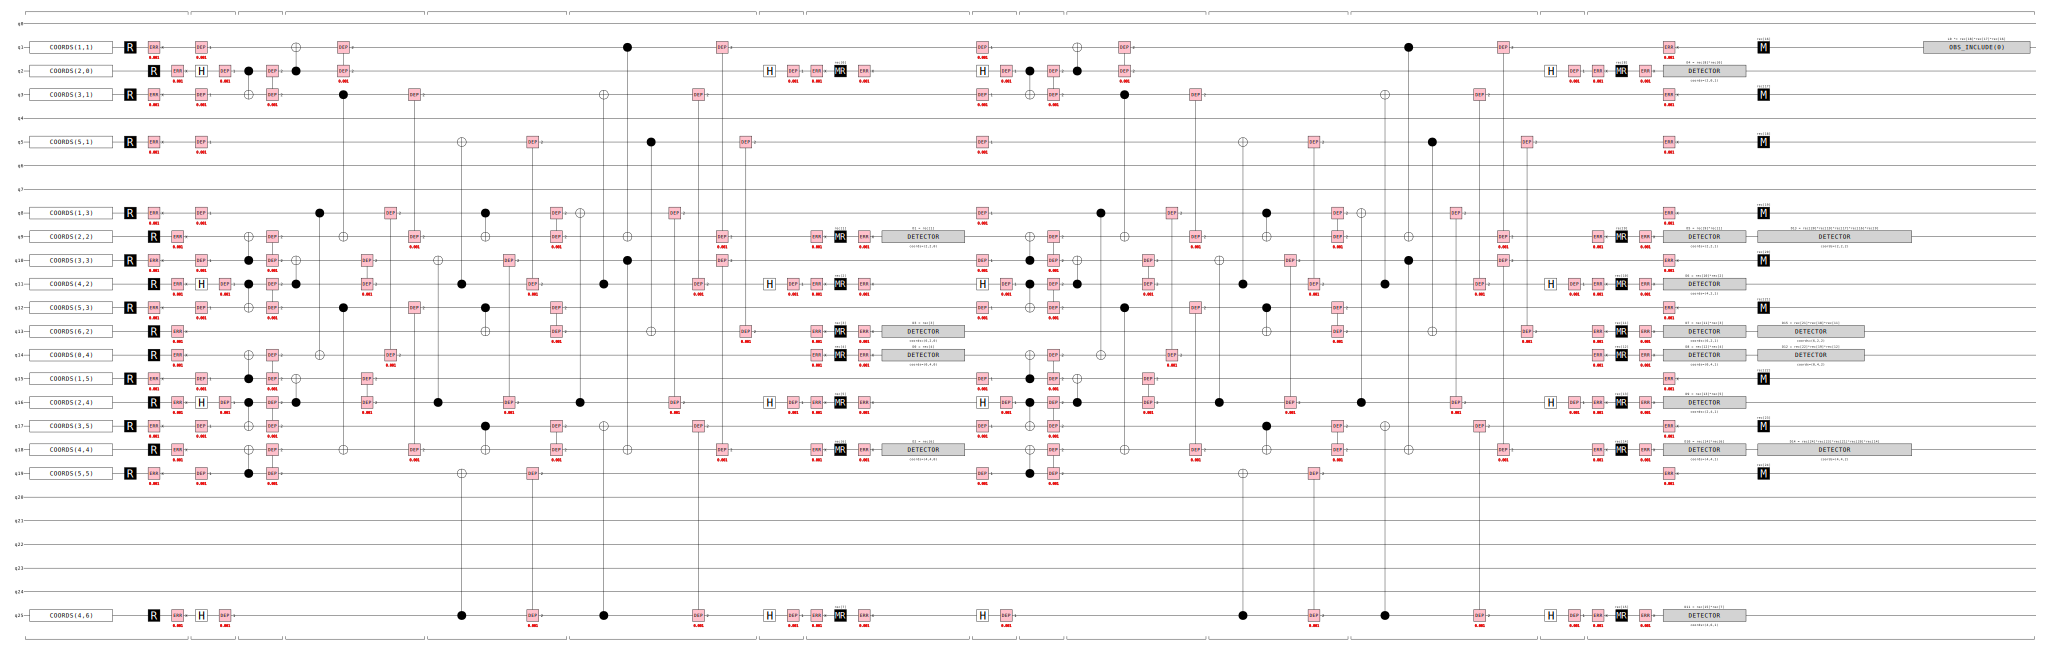

In [11]:
c = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=2,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

print(c)
display(c.diagram("timeline-svg"))

### Timeslice diagram
This view shows the circuit **one tick at a time** as spatial slices. Each panel corresponds to a `TICK`; within a panel, qubits appear at their `QUBIT_COORDS` \((x, y)\). Glyphs indicate what happens **during that tick**: edges for `CNOT` couplings, symbols for `R`/`H`/`MR`, diamonds for `DETECTOR`s, and tags for `OBSERVABLE_INCLUDE`. Use it to verify **ordering** (ticks separate layers), **locality** (nearest-neighbor links), and the alternation of **Z/X check** layers. You can zoom the SVG to inspect labels and coordinates.

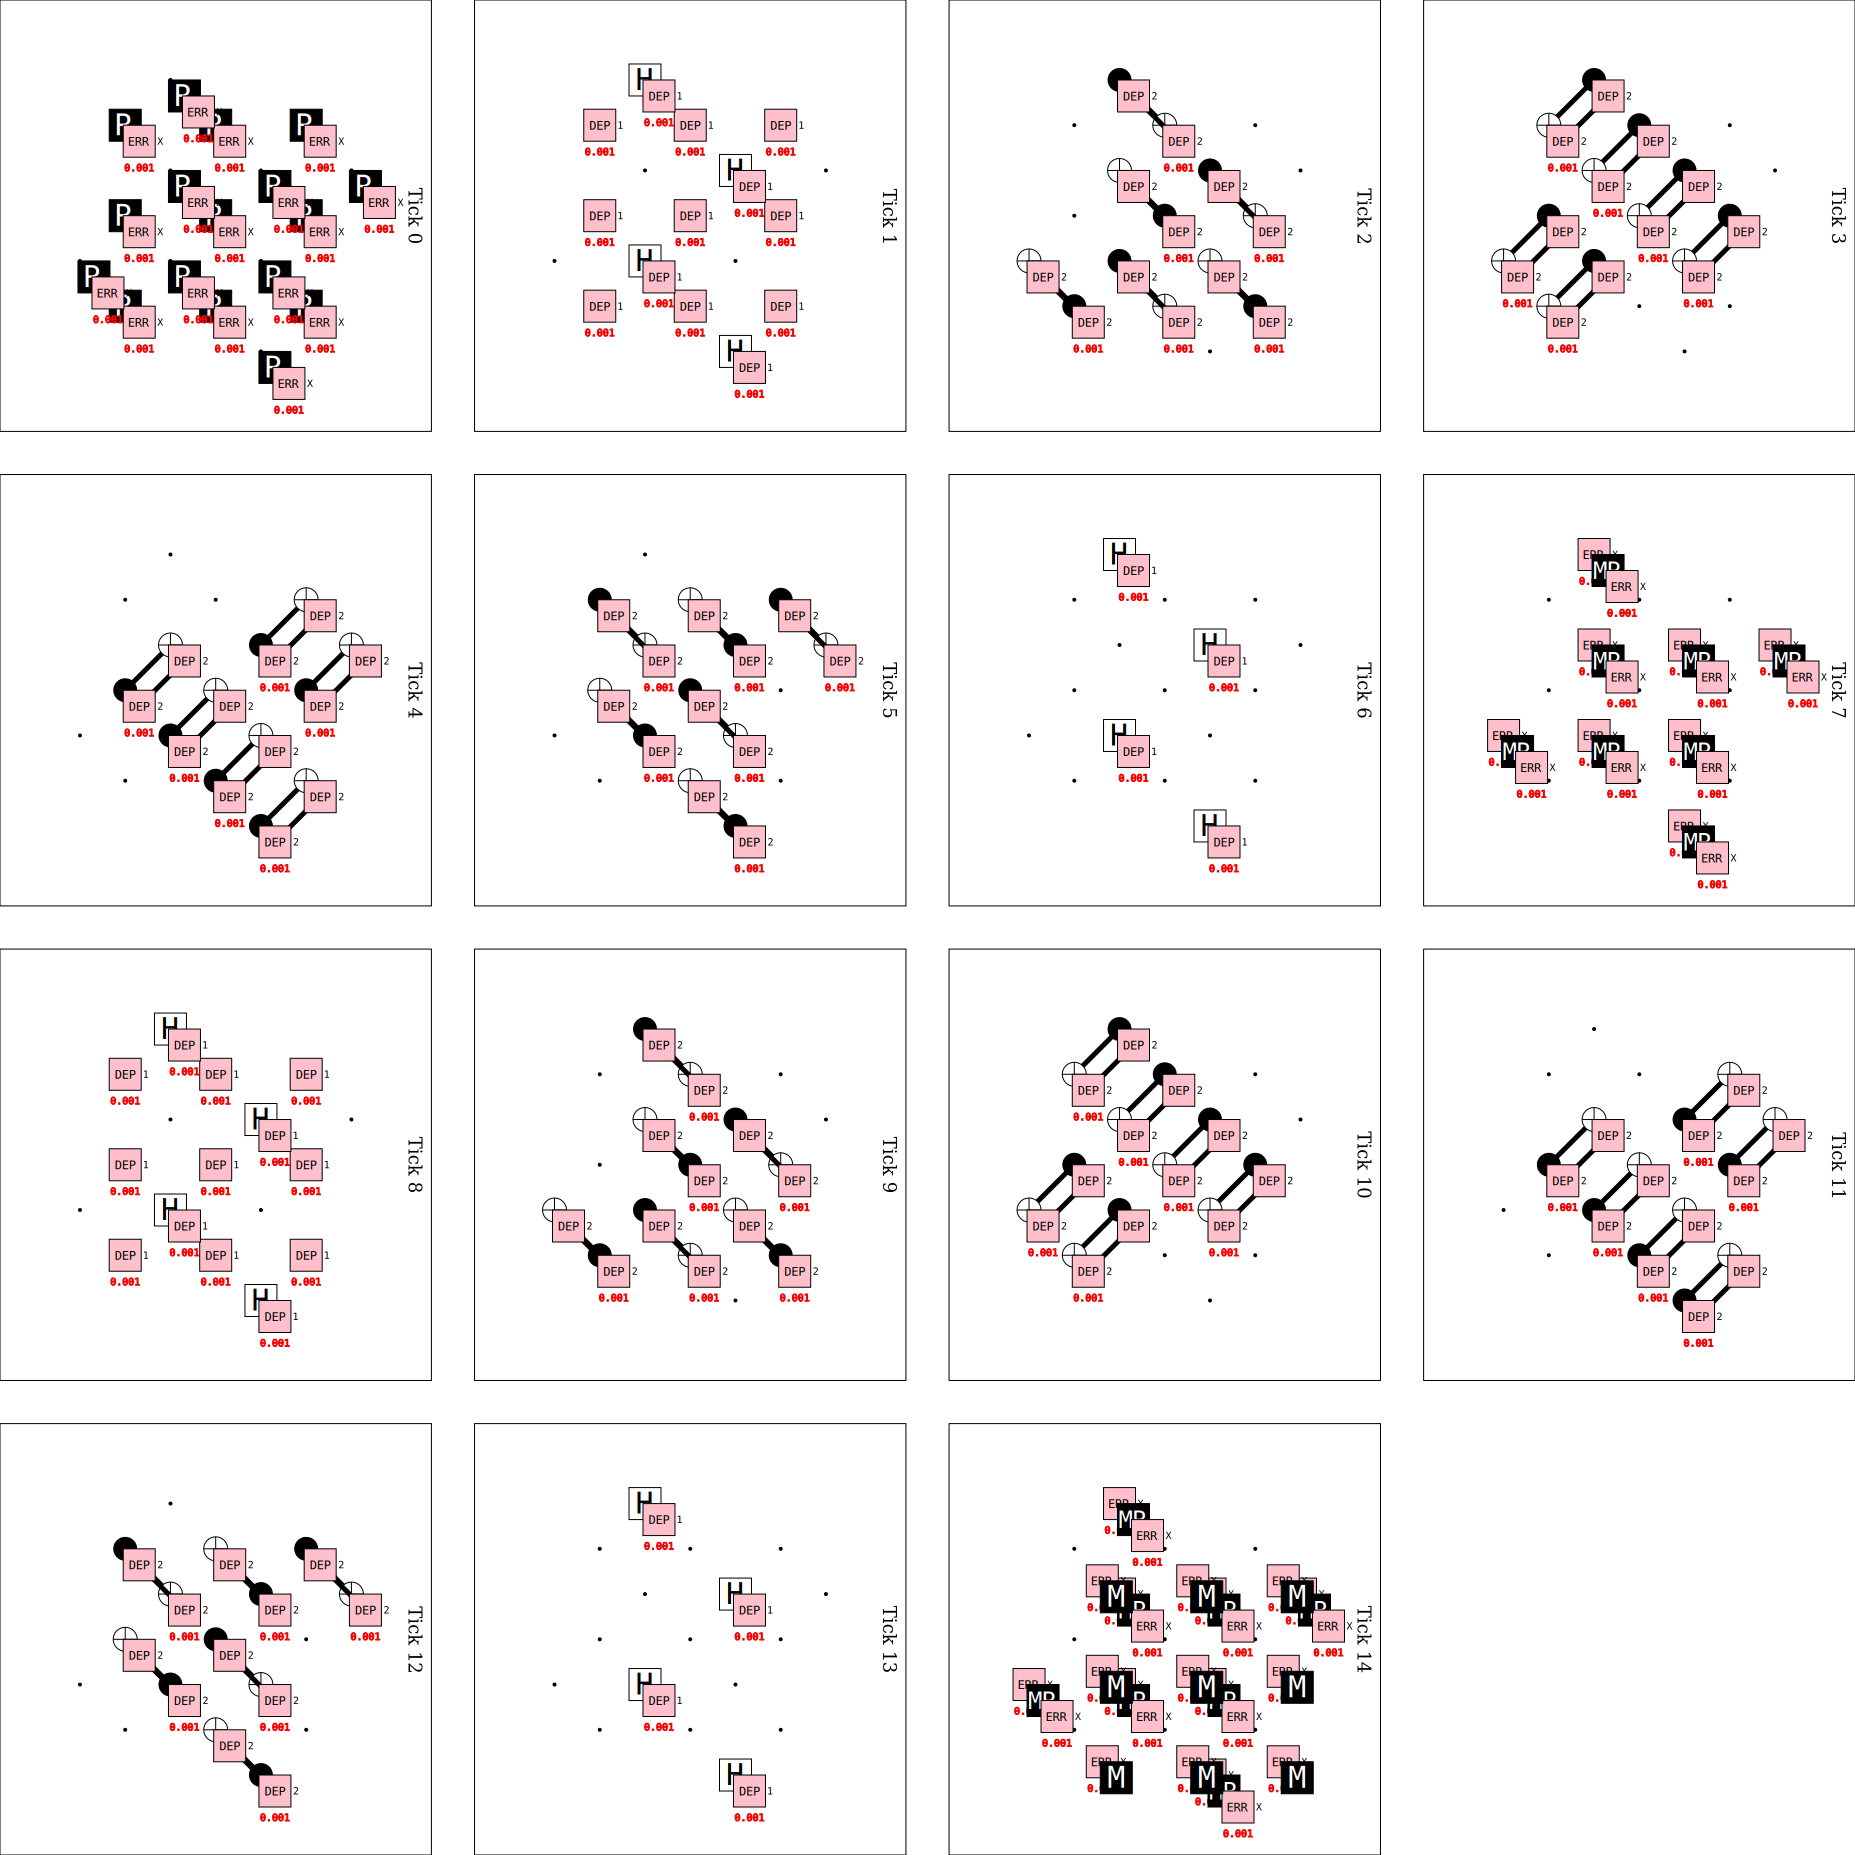

In [12]:
display(c.diagram("timeslice-svg"))

### Detector slice (with ops)
This view overlays each **DETECTOR** with the exact **operations and measurements** that feed into it, slice-by-slice across ticks. It’s ideal for debugging: you can see which `R`, `CNOT`, `H`, and `MR` events contribute to each detector and quickly spot conflicts that cause **non-deterministic detectors**. Detectors are labeled by their coordinates (e.g., `D16`), and the SVG lets you zoom to inspect paths and annotations.

*Tip:* Narrow the view when hunting issues by selecting a tick range or specific detectors via `tick=` and `filter_coords=`.


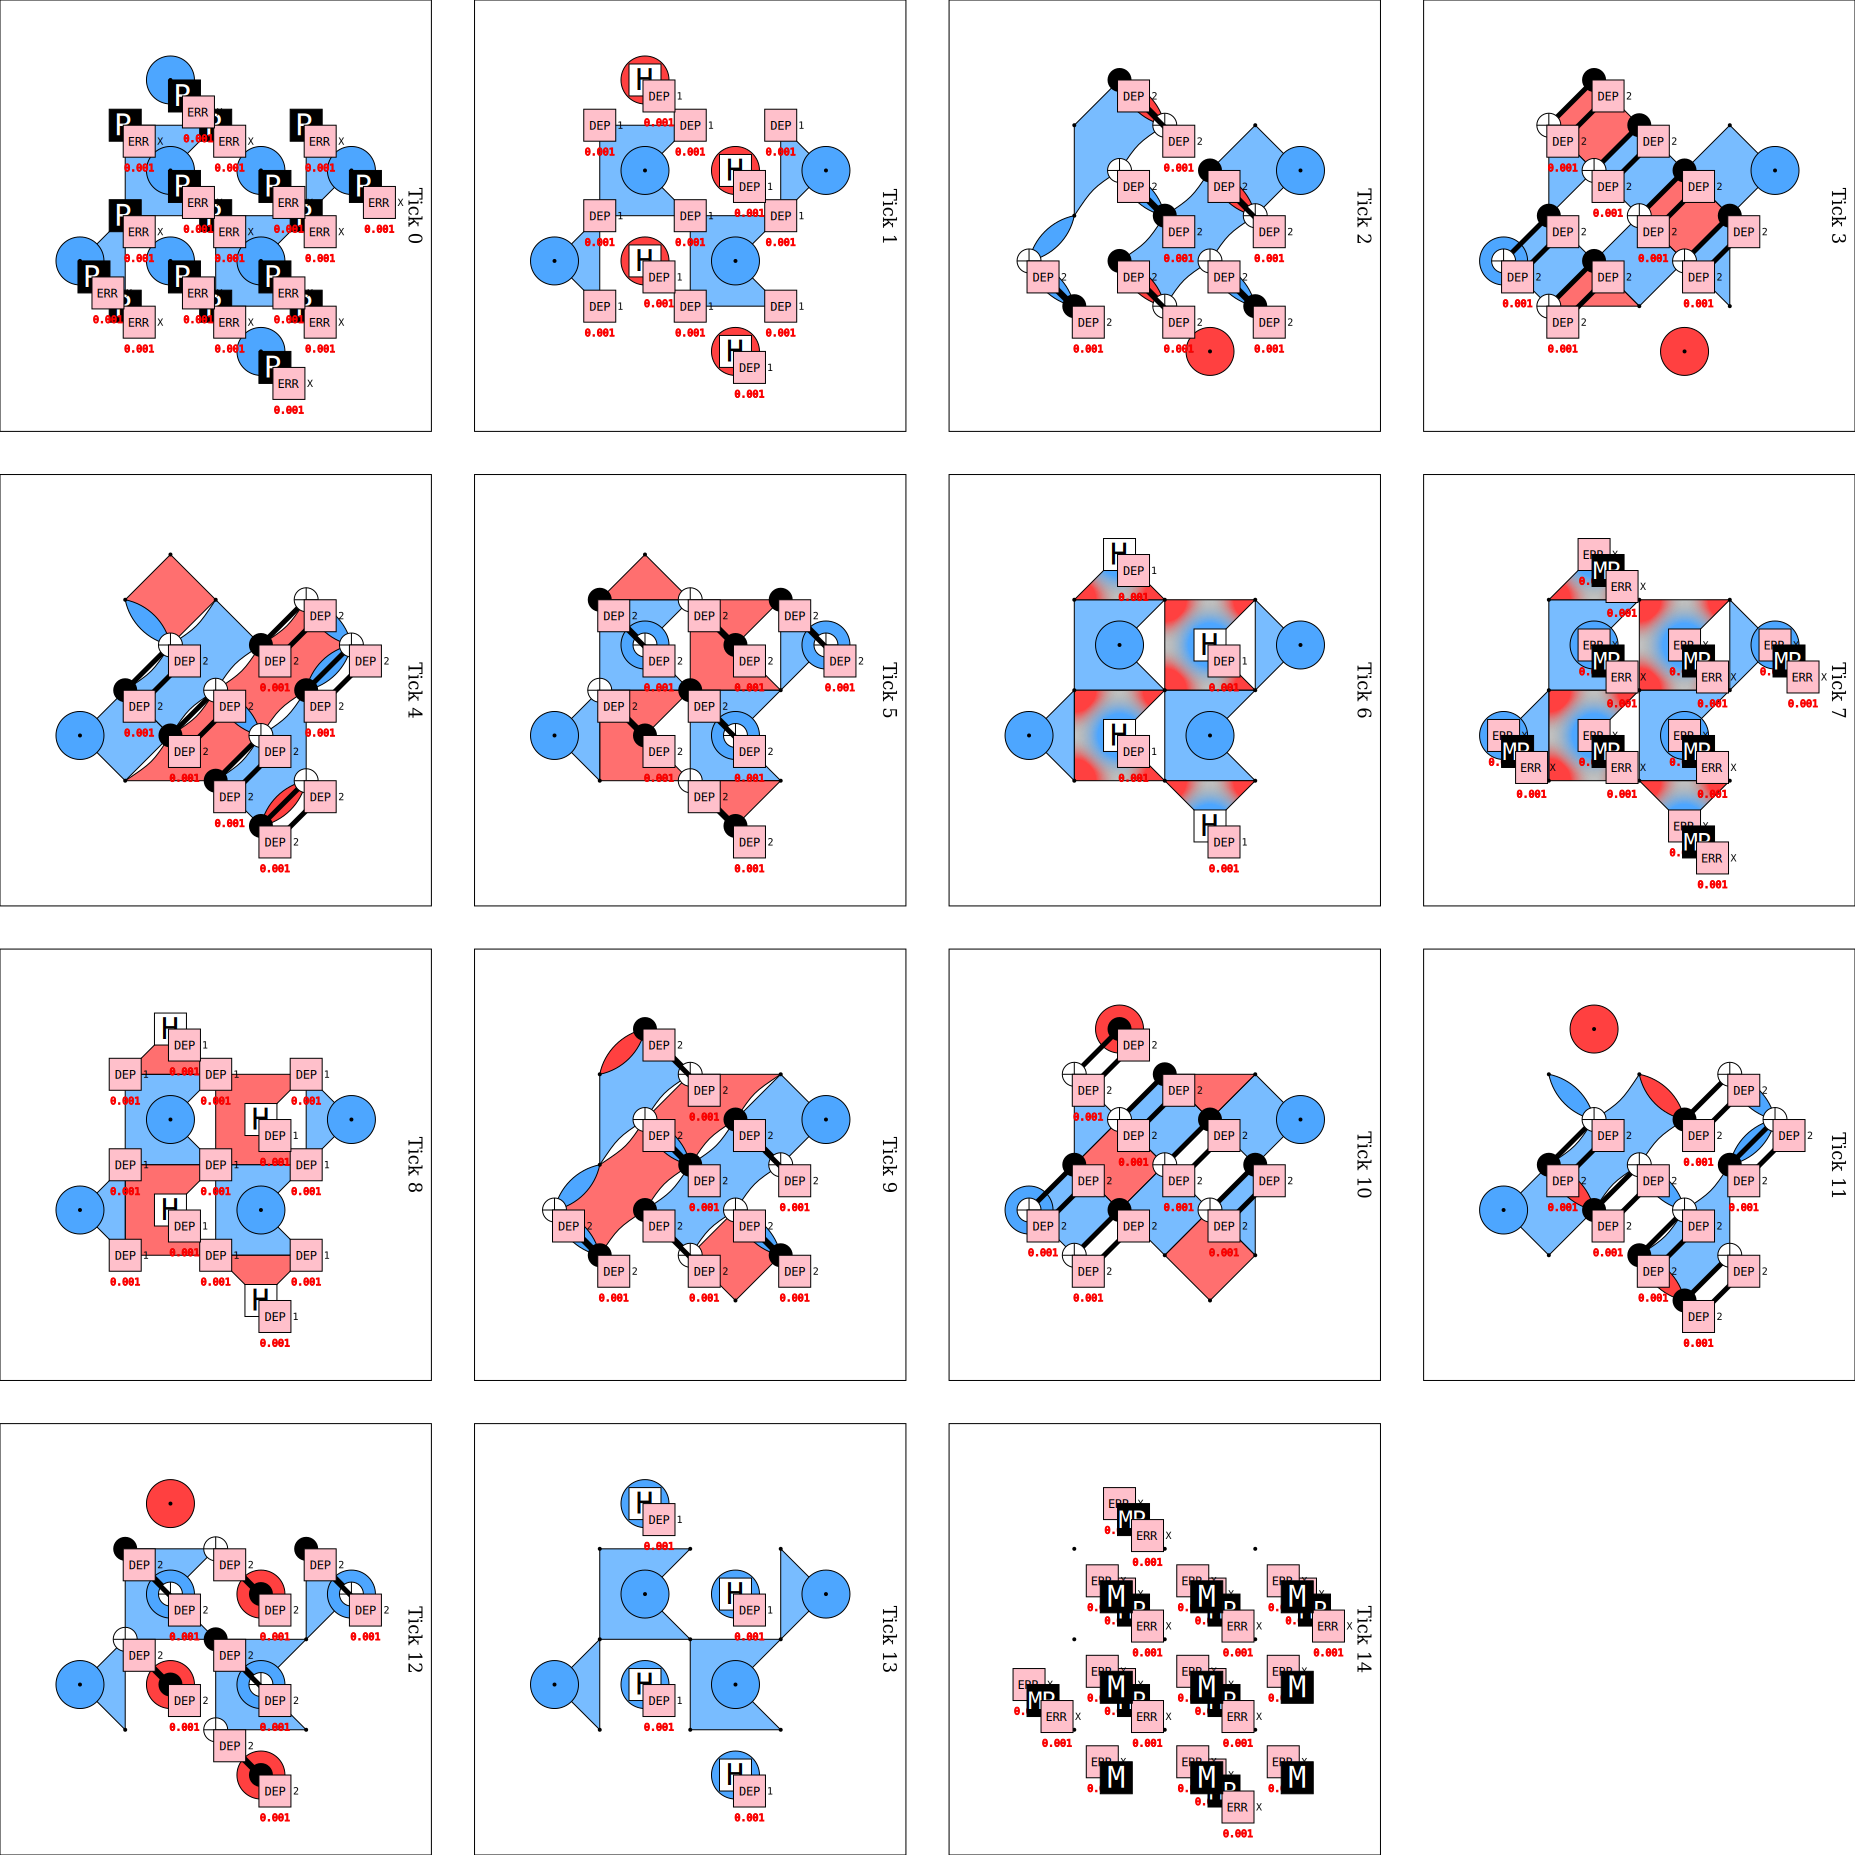

In [13]:
display(c.diagram("detslice-with-ops-svg"))

# Surface-Code Patch (Default / Unrotated) — n = 3 → L = 5

This is the **default (unrotated) planar surface code** layout on a 5×5 grid with
row-major indexing **q = x·L + y** (x = row, y = column).

**Role by parity (x, y):**
- **X-check ancilla** at **even, even**  (vertex/star checks)
- **Z-check ancilla** at **odd, odd**    (plaquette checks)
- **Data qubit** on edges: **even, odd** (horizontal) and **odd, even** (vertical)

---

## Qubit indices by role (L = 5)

- **Data (`dat_qubits`)**  
  Horizontal edges (even, odd): `1, 3, 11, 13, 21, 23`  
  Vertical edges (odd, even): `5, 7, 9, 15, 17, 19`  
  **All data (sorted):** `1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23`

- **Z-check ancillas (`z_st_qubits`)** (odd, odd)  
  `6, 8, 16, 18`

- **X-check ancillas (`x_st_qubits`)** (even, even)  
  `0, 2, 4, 10, 12, 14, 20, 22, 24`

- **Measurements per round (ancillas):**  
  `meas_per_round = len(x_st_qubits) + len(z_st_qubits) = 9 + 4 = 13`

---

## Coordinates by role

- **Data (`dat_coords`)**  
  Horizontal (even, odd): `(0,1), (0,3), (2,1), (2,3), (4,1), (4,3)`  
  Vertical (odd, even): `(1,0), (1,2), (1,4), (3,0), (3,2), (3,4)`

- **Z-checks (`z_st_coords`)** (odd, odd)  
  `(1,1), (1,3), (3,1), (3,3)`

- **X-checks (`x_st_coords`)** (even, even)  
  `(0,0), (0,2), (0,4), (2,0), (2,2), (2,4), (4,0), (4,2), (4,4)`

---

## 5×5 lattice (role and linear index)

Rows are **x = 0…4**, columns are **y = 0…4**.



In [18]:
n = 3
L = n*2 - 1
rounds = 2

c = stim.Circuit()
dat_coords = []
dat_qubits = []
for x in range(n):
    for y in range(n):
        dat_coords.append((2 * x, 2 * y))
        dat_qubits.append(2 * x * L + 2 * y)
    if x < n - 1:
        for y in range(n - 1):
            dat_coords.append((2 * x + 1, 2 * y + 1))
            dat_qubits.append((2 * x + 1) * L + 2 * y + 1)

z_st_coords = []
z_st_qubits = []
for x in range(n):
    for y in range(n - 1):
        z_st_coords.append((2 * x, 2 * y + 1))
        z_st_qubits.append(2 * x * L + 2 * y + 1)

x_st_coords = []
x_st_qubits = []
for x in range(n - 1):
    for y in range(n):
        x_st_coords.append((2 * x + 1, 2 * y))
        x_st_qubits.append((2 * x + 1) * L + 2 * y)

meas_per_round = len(x_st_qubits + z_st_qubits)

print("dat_qubits: ", dat_qubits)
print("z_st_qubits: ", z_st_qubits)
print("x_st_qubits: ", x_st_qubits)
print("dat_coords: ", dat_coords)
print("z_st_coords: ", z_st_coords)
print("x_st_coords: ", x_st_coords)

# coords
for x in range(L):
    for y in range(L):
        c.append("QUBIT_COORDS", [L * x + y], [x, y])

dat_qubits:  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
z_st_qubits:  [1, 3, 11, 13, 21, 23]
x_st_qubits:  [5, 7, 9, 15, 17, 19]
dat_coords:  [(0, 0), (0, 2), (0, 4), (1, 1), (1, 3), (2, 0), (2, 2), (2, 4), (3, 1), (3, 3), (4, 0), (4, 2), (4, 4)]
z_st_coords:  [(0, 1), (0, 3), (2, 1), (2, 3), (4, 1), (4, 3)]
x_st_coords:  [(1, 0), (1, 2), (1, 4), (3, 0), (3, 2), (3, 4)]


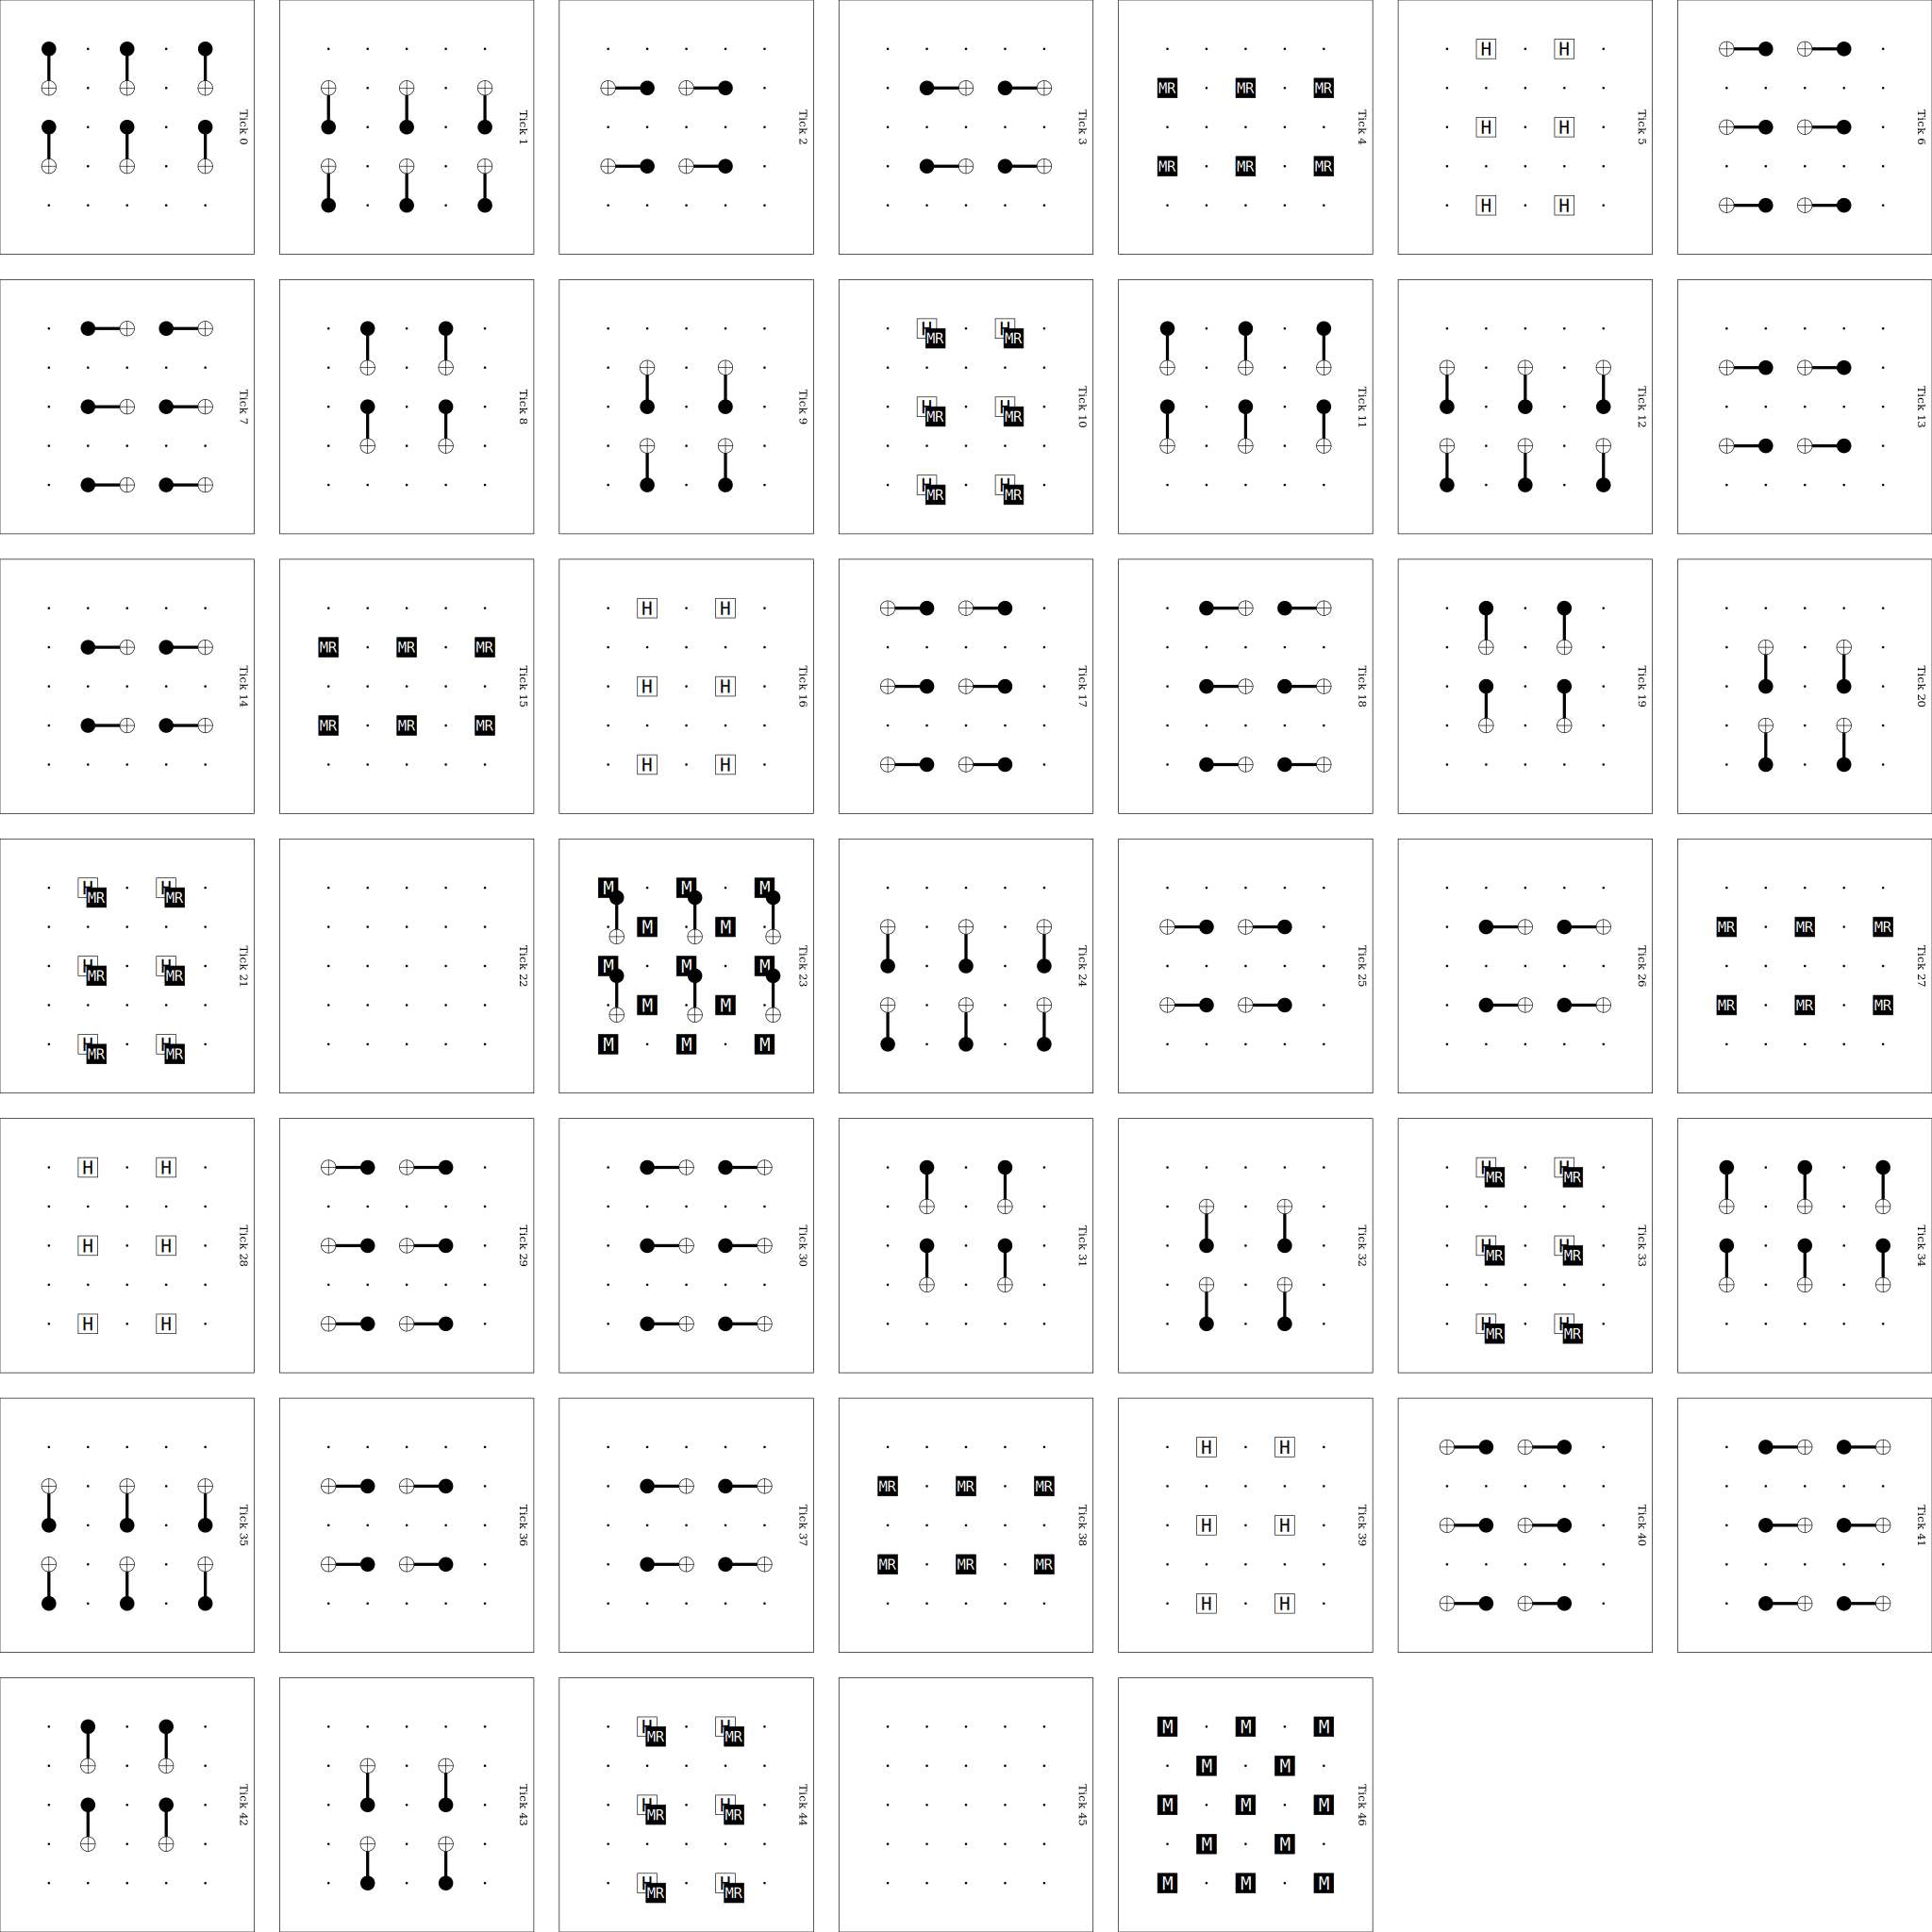

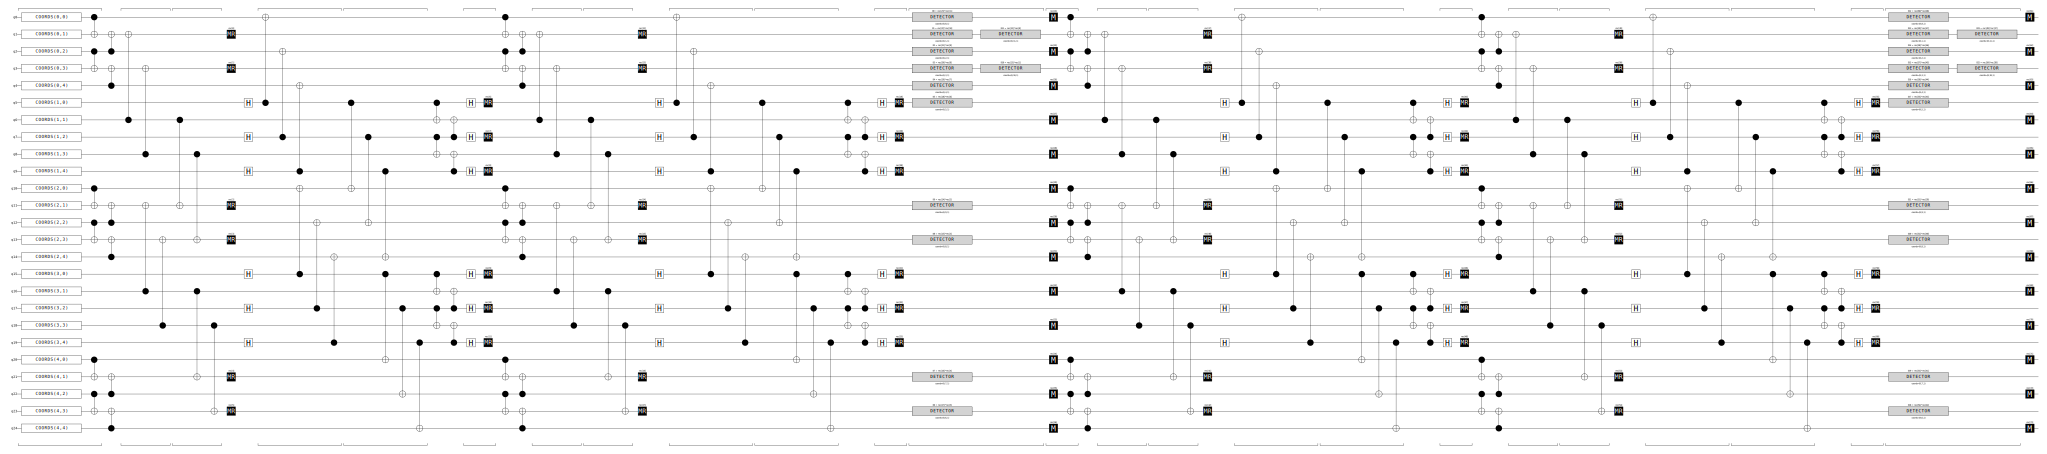

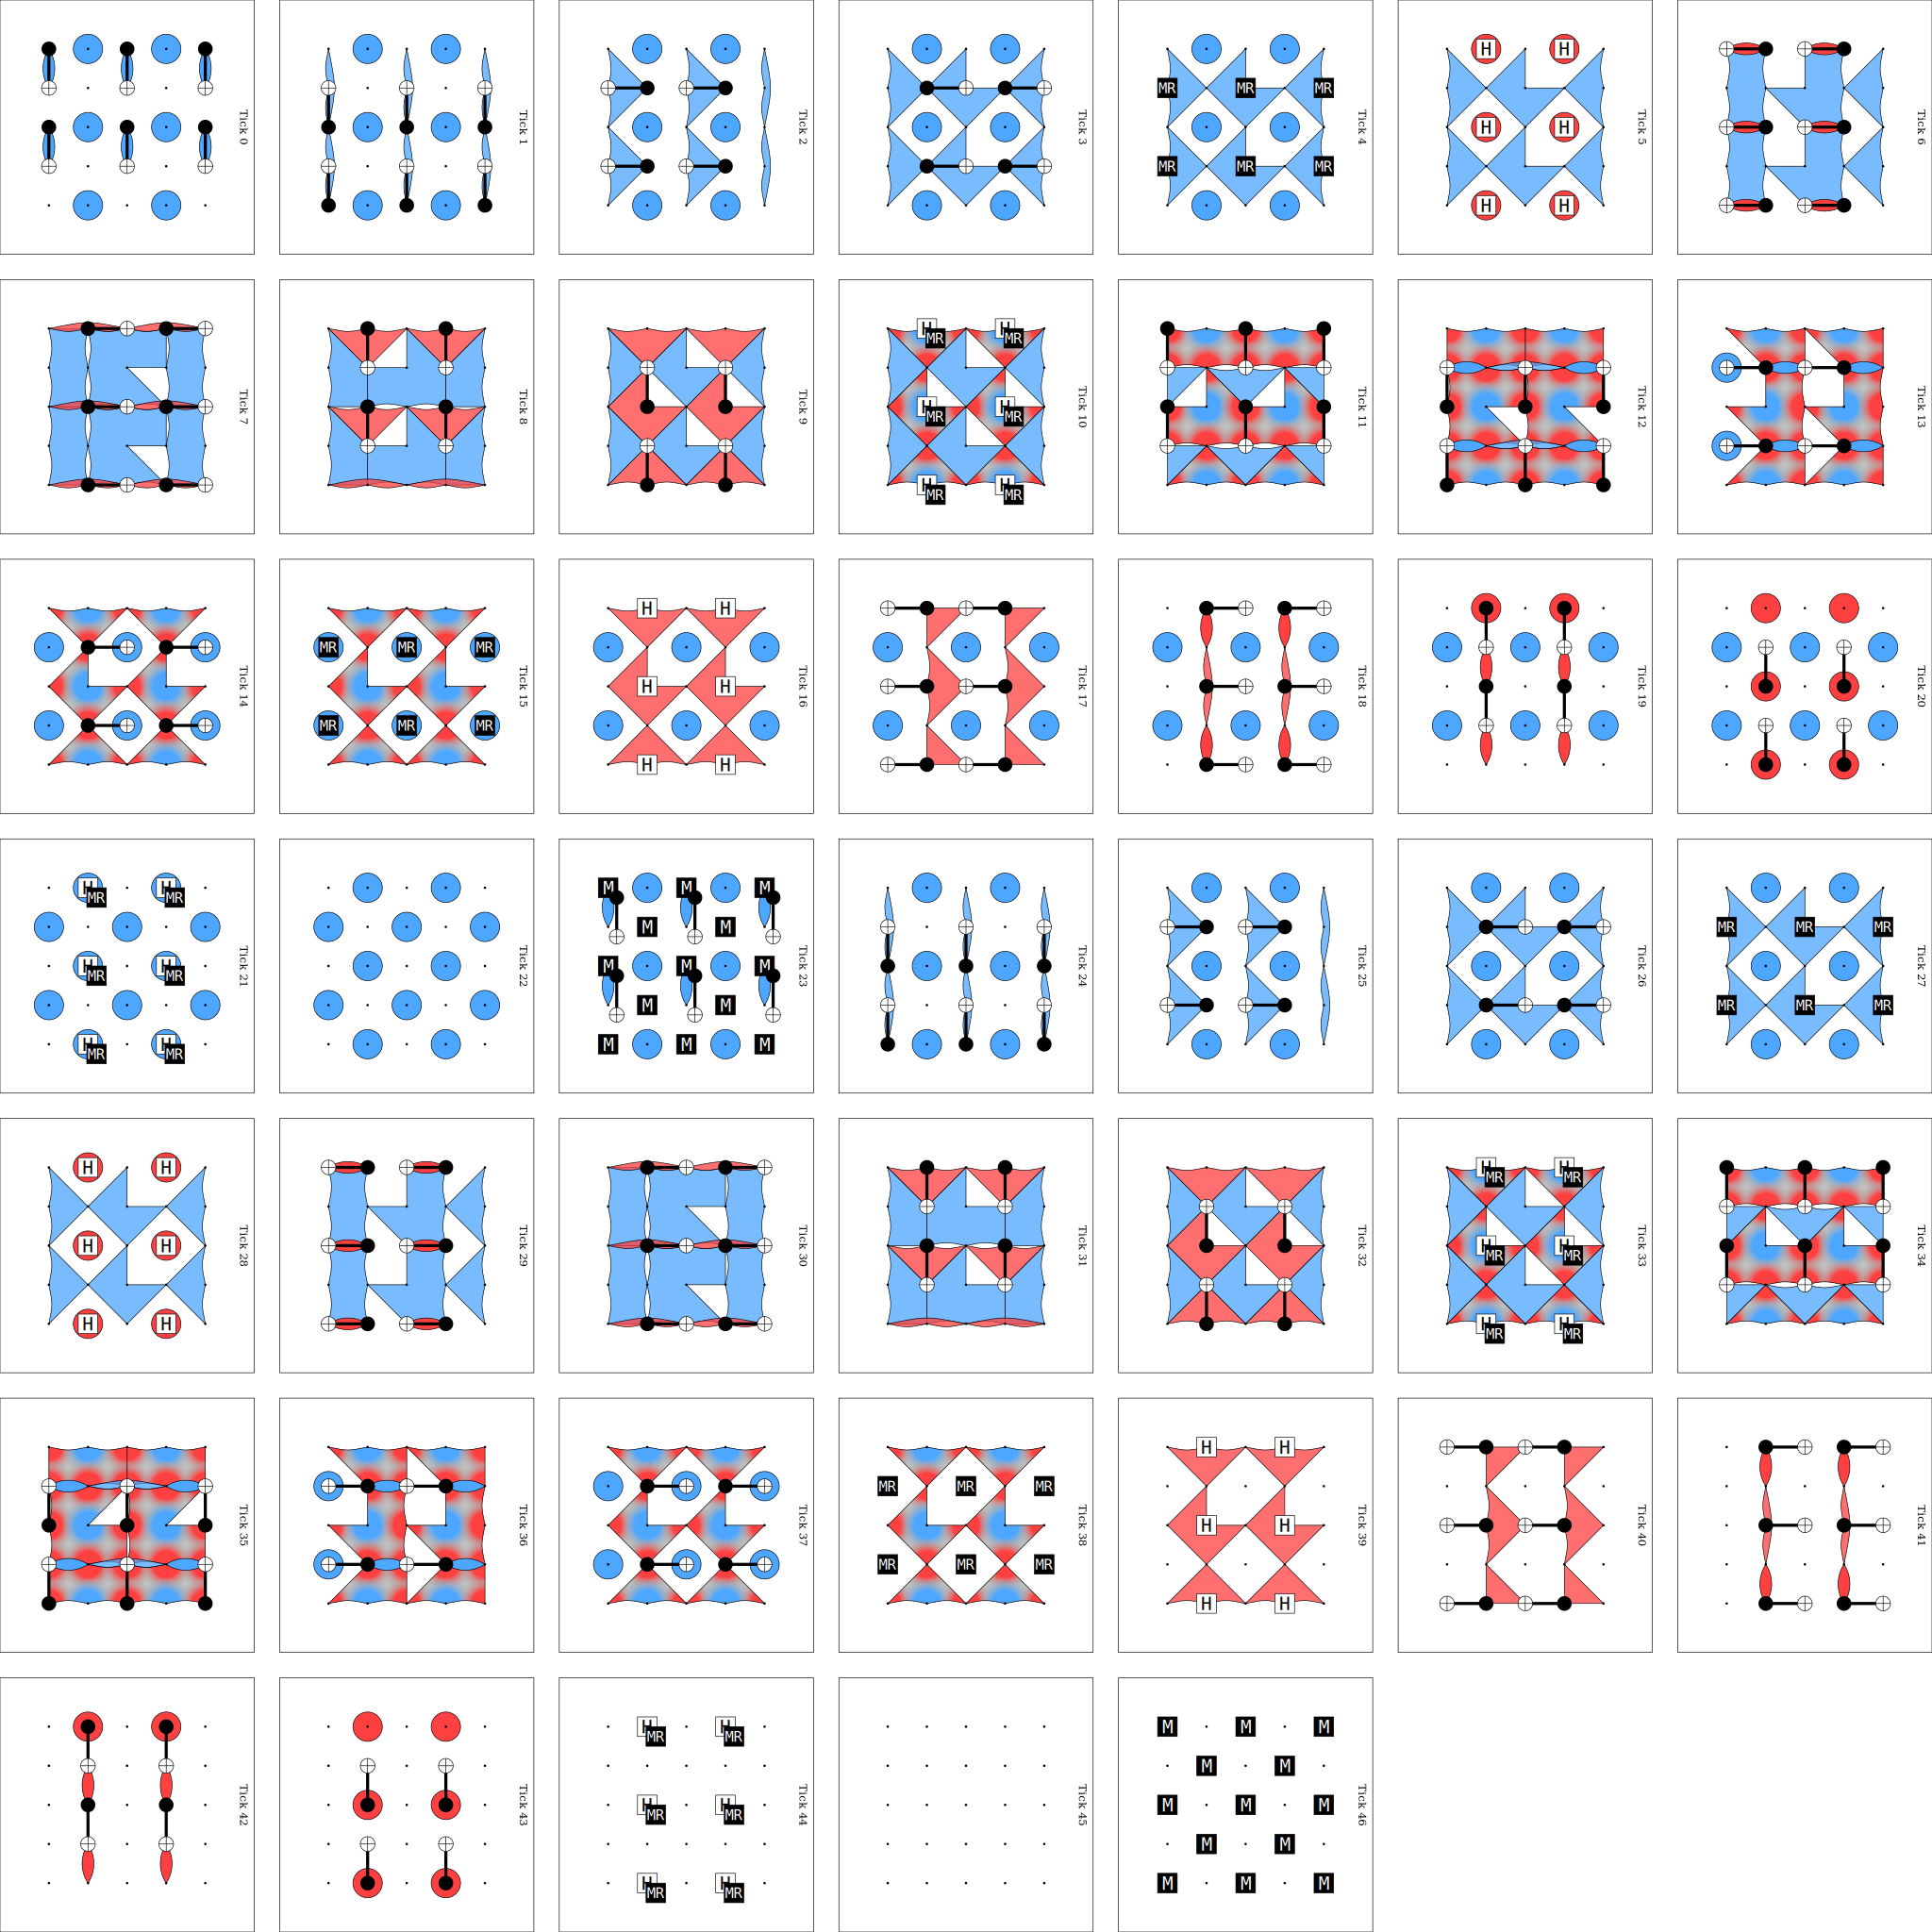

DEM length: 24


In [21]:
for t in range(rounds):

    # your Z entangling pattern
    for i in range(len(dat_qubits)):
        if dat_coords[i][0] % 2 == 0 and dat_coords[i][1] < L - 1:
            c.append("CNOT", [dat_qubits[i], dat_qubits[i] + 1])
    c.append("TICK")
    for i in range(len(dat_qubits)):
        if dat_coords[i][0] % 2 == 0 and dat_coords[i][1] > 0:
            c.append("CNOT", [dat_qubits[i], dat_qubits[i] - 1])
    c.append("TICK")
    for i in range(len(dat_qubits)):
        if dat_coords[i][0] % 2 == 1:
            c.append("CNOT", [dat_qubits[i], dat_qubits[i] - L])
    c.append("TICK")
    for i in range(len(dat_qubits)):
        if dat_coords[i][0] % 2 == 1:
            c.append("CNOT", [dat_qubits[i], dat_qubits[i] + L])
    c.append("TICK")

    # measure Z ancillas this round
    c.append("MR", z_st_qubits)
    c.append("TICK")

    # X stabilizers (ancillas in |+>, measure X parity)
    c.append("H", x_st_qubits)
    c.append("TICK")

    # your X entangling pattern
    for i in range(len(dat_qubits)):
        if dat_coords[i][0] % 2 == 0 and dat_coords[i][0] < L - 1:
            c.append("CNOT", [dat_qubits[i] + L, dat_qubits[i]])
    c.append("TICK")
    for i in range(len(dat_qubits)):
        if dat_coords[i][0] % 2 == 0 and dat_coords[i][0] > 0:
            c.append("CNOT", [dat_qubits[i] - L, dat_qubits[i]])
    c.append("TICK")
    for i in range(len(dat_qubits)):
        if dat_coords[i][0] % 2 == 1:
            c.append("CNOT", [dat_qubits[i] - 1, dat_qubits[i]])
    c.append("TICK")
    for i in range(len(dat_qubits)):
        if dat_coords[i][0] % 2 == 1:
            c.append("CNOT", [dat_qubits[i] + 1, dat_qubits[i]])
    c.append("TICK")

    # rotate back to Z basis to use MR
    c.append("H", x_st_qubits)
    c.append("MR", x_st_qubits)
    c.append("TICK")

    # ---- Build detectors as parity between rounds ----
    # NOTE: we rely on measuring [z_st_qubits then x_st_qubits] each round in a fixed order.
    # That makes meas_per_round records per round, in the SAME order every round.
    if t > 0:
        # add detectors for ALL ancilla outcomes this round vs previous round
        for st in range(meas_per_round):
            # current round record index: - (st+1)
            # previous round record index: - (st+1 + meas_per_round)
            c.append(
                "DETECTOR",
                [stim.target_rec(-(st+1)), stim.target_rec(-(st+1 + meas_per_round))],
                [0, st, t]
            )
        c.append("TICK")

c.append("M", dat_qubits)


# def q_to_det_idx(q):
#     if q % 2 == 0:
#         return -(L**2//2 + 1 - q//2)
#     else:
#         return -(L**2 - q//2)

# def neighbors(idx, L):
#     """Return N,S,E,W neighbors of a site in an LxL grid."""
#     x, y = divmod(idx, L)        # row = x, col = y
#     nbrs = []
#     if x > 0:      nbrs.append((x-1)*L + y)   # north
#     if x < L-1:    nbrs.append((x+1)*L + y)   # south
#     if y > 0:      nbrs.append(x*L + (y-1))   # west
#     if y < L-1:    nbrs.append(x*L + (y+1))   # east
#     return nbrs

# sort_st = x_st_qubits + z_st_qubits
# sort_st.sort()
# for q in sort_st:
#     targets = [stim.target_rec(q_to_det_idx(q))]
#     for nb in neighbors(q, L):
#         targets.append(stim.target_rec(q_to_det_idx(nb)))
        
#     c.append("DETECTOR", targets, [(q//L), (q%L), rounds])


# (Optional) diagrams
display(c.diagram("timeslice-svg"))
display(c.diagram("timeline-svg"))
display(c.diagram("detslice-with-ops-svg"))

# This should now succeed without "non-deterministic detectors".
detector_error_model = c.detector_error_model(decompose_errors=True)

print("DEM length:", len(str(detector_error_model).splitlines()))